In [83]:
import pickle
import numpy as np
import pandas as pd
from Ensemble import *
from TsCompDb import TsCompDb
from ImportModel import read_geotop, read_forcing
from pathlib import Path
from datetime import datetime

import random
import math
import os
from statistics import mean, stdev
from scipy import stats
from scipy.stats import t

from bokeh.plotting import figure, show, output_notebook 
from bokeh.layouts import row, gridplot
from bokeh.models import ColumnDataSource, BoxAnnotation,Label, LabelSet, Span, Range1d
from bokeh.io import export_png, export_svgs
from bokeh.palettes import brewer, d3

# shell net ftp account
# somewhere he can ssh in

# DEGREE OF CONFIDENCE INTERVAL TO CALCULATE
confidence = 0.95

# Should I get observations from the Database or from pickle
get_fresh_db = False

# Model results from text file or from pickle
get_fresh_local = False

# Observations
# Observations stored as a dictionary or series
obs_pickle = "annual-pickles/point_obs_dict.pickle"
obs_pickle_path = Path(obs_pickle)

# Simple GEOtop models
era5_geotop_simple_pickle = "annual-pickles/era5_geotop_simple_dict.pickle"
era5_geotop_simple_pickle_path = Path(era5_geotop_simple_pickle)

jra55_geotop_simple_pickle = "annual-pickles/jra55_geotop_simple_dict.pickle"
jra55_geotop_simple_pickle_path = Path(jra55_geotop_simple_pickle)

# Complex GEOtop models
era5_geotop_complex_pickle = "annual-pickles/era5_geotop_complex_dict.pickle"
era5_geotop_complex_pickle_path = Path(era5_geotop_complex_pickle)

jra55_geotop_complex_pickle = "annual-pickles/jra55_geotop_complex_dict.pickle"
jra55_geotop_complex_pickle_path = Path(jra55_geotop_complex_pickle)

# Simple focing-based models
era5_forcing_pickle = "annual-pickles/era5_forcing_dict.pickle"
era5_forcing_pickle_path = Path(era5_forcing_pickle)

jra55_forcing_pickle = "annual-pickles/jra55_forcing_dict.pickle"
jra55_forcing_pickle_path = Path(jra55_forcing_pickle)

# These are the points I'm investigating
ts_points = ['NGO-RC-167_ST01']

In [84]:
# GET OBSERVATION DATA FROM DB - if they need to be fresh, or if no pickle exists
if (get_fresh_db or not obs_pickle_path.is_file()):
    user_name = "readonly"
    password = "Cup7Quan0awP"
    host = "permafrost.gcrc.carleton.ca"
    db_name = "observations"

    # Connect to the database
    pf_db = TsCompDb (host, db_name, user_name, password)


    # Get data for the selected points as a dictionary of Series
    point_obs_dict = pf_db.get_point_daily_ts_dict(ts_points)

    # Close out DB connection
    pf_db.close()
    
    pd.to_pickle(point_obs_dict, obs_pickle)

else:
    point_obs_dict = pd.read_pickle(obs_pickle)

In [85]:
# GET MODEL RESULTS FROM LOCAL DISK

# Get model results from text files - if they need to be fresh, or if no pickle exists
if (get_fresh_local or not (era5_geotop_simple_pickle_path.is_file() and jra55_geotop_simple_pickle_path.is_file() and era5_geotop_complex_pickle_path.is_file() and jra55_geotop_complex_pickle_path.is_file())):
    # Read geotop results from the outs directory
    #point_model_dict = read_geotop("era5_outs",4)
    #pd.to_pickle(point_model_dict, models_pickle)
    
    era5_geotop_simple_dict = read_geotop("era5_simple_results",4)
    pd.to_pickle(era5_geotop_simple_dict, era5_geotop_simple_pickle)
    
    jra55_geotop_simple_dict = read_geotop("jra55_simple_results",4)
    pd.to_pickle(jra55_geotop_simple_dict, jra55_geotop_simple_pickle)
    
    era5_geotop_complex_dict = read_geotop("era5_compleTx_results",4)
    pd.to_pickle(era5_geotop_complex_dict, era5_geotop_complex_pickle)
    
    jra55_geotop_complex_dict = read_geotop("jra55_complex_results",4)
    pd.to_pickle(jra55_geotop_complex_dict, jra55_geotop_complex_pickle)
else:
    #point_model_dict = pd.read_pickle(models_pickle)
    era5_geotop_simple_dict = pd.read_pickle(era5_geotop_simple_pickle)
    jra55_geotop_simple_dict = pd.read_pickle(jra55_geotop_simple_pickle)
    
    era5_geotop_complex_dict = pd.read_pickle(era5_geotop_complex_pickle)
    jra55_geotop_complex_dict = pd.read_pickle(jra55_geotop_complex_pickle)    

In [86]:
# GET ERA5 AIR-3 MODEL FROM LOCAL DISK

# Get model results from text files - if they need to be fresh, or if no pickle exists
if (get_fresh_local or not (era5_forcing_pickle_path.is_file() and jra55_forcing_pickle_path.is_file())):
    # Read forcing results from the directory
    #point_forcing_dict = read_forcing("era5_forcing","ERA5", 5)
    #pd.to_pickle(point_forcing_dict, era5_forcing_pickle)
    
    era5_forcing_dict = read_forcing("era5_forcing","ERA5", 5)
    pd.to_pickle(era5_forcing_dict, era5_forcing_pickle)
    
    jra55_forcing_dict = read_forcing("jra55_forcing","JRA55", 5)
    pd.to_pickle(jra55_forcing_dict, jra55_forcing_pickle)
else:
    #point_forcing_dict = pd.read_pickle(jra55_forcing_pickle)
    era5_forcing_dict = pd.read_pickle(era5_forcing_pickle)
    jra55_forcing_dict = pd.read_pickle(jra55_forcing_pickle)

In [87]:
point_details = pd.read_csv("PointDetails.csv", index_col=0)

In [131]:
# Create an ensemble object for each observation point
ensemble_dict = {}

for idx, row_vals in point_details.iterrows():
    ensemble_dict[idx] = ensemble(idx, row_vals["latitude_dd"], row_vals["longitude_dd"], 0, row_vals["elevation_m"], row_vals["ground_type"])
    ensemble_dict[idx].set_observation_ts(point_obs_dict[idx])

In [133]:
# Add GEOtop results to each model ensemble
for i in point_obs_dict:
    ensemble_dict[i].add_model_ts(era5_geotop_simple_dict[i], "GT-ERA5")
    ensemble_dict[i].add_model_ts(jra55_geotop_simple_dict[i], "GT-JRA55")
    ensemble_dict[i].add_model_ts(era5_geotop_complex_dict[i], "GT-BSnow-ERA5")
    ensemble_dict[i].add_model_ts(jra55_geotop_complex_dict[i], "GT-BSnow-JRA55")

In [134]:
for i in era5_forcing_dict:
    ensemble_dict[i].add_model_ts(era5_forcing_dict[i]/2, "ERA5/2")

for i in jra55_forcing_dict:
    ensemble_dict[i].add_model_ts(jra55_forcing_dict[i]/2, "JRA55/2")

In [135]:
year_start_date = '01-Sep'

#all_accordance_funcs = {'RMSE':rmse, 'MAE':mae, 'r^2':r_squared, 'Willmott d':willmott_d,
#                        "Willmott d one":willmott_d_one, "Willmott refined d":willmott_refined_d, 
#                        "Nash-Sutcliffe efficiency":nse, "E one":nse_one}

#all_accordance_funcs = {'r^2':r_squared, 'MAE':mae,'RMSE':rmse, "Nash-Sutcliffe efficiency":nse, 'Willmott d':willmott_d,
                        #"Willmott d one":willmott_d_one, "Willmott refined d":willmott_refined_d, "E one":nse_one}

all_accordance_funcs = {'RMSE':rmse, "Willmott d one":willmott_d_one, "E one":nse_one}

subscripted_measure_names = {'r^2':'r²', 'Nash-Sutcliffe efficiency':'NSE', 'MAE':'MAE', 'RMSE':'RMSE', 'Willmott d':'d', 
                             'Willmott d one':'d₁', "Willmott refined d":'dᵣ', "E one":'E₁'}

all_accordance_results = {}
all_accordance_rankings = {}


    

In [136]:

def year_split(df):
    l = {}
    for year in df.index.year.unique():
        df_year = df[df.index.year == year]
        if len(df_year) > 360:
            l[year] = df_year
    return l
for m in all_accordance_funcs:
    accordance_func = all_accordance_funcs[m]

    # Split all observation and model time-series into years based on years present in observations
    # Then calculated accordances on the split timeseries for the complete years, store results
    # in dictionary accordance_dict_year, key is name of point, data is dataframe containing accordances
    # of every model in the ensemble for years for which there's complete observations

    over_one_year = []
    accordance_dict_year = {}

    for i in point_obs_dict:

        obs_ensemble_ts = ensemble_dict[i].get_observation_ts()

        model_ensemble_ts = ensemble_dict[i].get_model_ts()

        split_obs_by_year = year_split(obs_ensemble_ts)
        
        if (len(split_obs_by_year) > 0):
            over_one_year.append(i)

            accordance_df = pd.DataFrame(index = list(split_obs_by_year.keys()))

            # Iterate through models
            # j is the name of the model, split_obs_by_year and split_model_by_year are dictionaries
            # containing the time-series to be compared. Can compare with a for loop, store results in a dataframe
            # indexed by date of the start of year where each column is a model and the data is the accordance.
            for j in model_ensemble_ts:
                split_model_by_year = year_split(model_ensemble_ts[j])
                model_accordance = []
                # Iterating through the time-periods
                for k in split_obs_by_year:
                    accordance = accordance_func(split_model_by_year[k], split_obs_by_year[k], 2)
                    model_accordance.append(accordance)
                accordance_df[j] = model_accordance
        accordance_dict_year[i] = accordance_df
    # Move accordance data out of dictionary and into a single DataFrame

    model_accordance_df =  pd.DataFrame(columns = ["GT-ERA5", "GT-JRA55", "GT-BSnow-ERA5","GT-BSnow-JRA55", "ERA5/2", "JRA55/2"])
    # Go through the dict of DFs and add name to years
    for i in accordance_dict_year:

        new_index = ['%s - %s' % (i,x) for x in list(pd.to_datetime(accordance_dict_year[i].index).strftime("%Y-%m-%d"))]
        accordance_dict_year[i]['point_idx'] = new_index
        reindexed_df = accordance_dict_year[i].set_index('point_idx')
        model_accordance_df = model_accordance_df.append(reindexed_df)

    all_accordance_results[m] = model_accordance_df
    if m in ['RMSE', 'MAE']:
        all_accordance_rankings[m] = model_accordance_df.rank(axis=1, method='average', ascending=True)
    else:
        all_accordance_rankings[m] = model_accordance_df.rank(axis=1, method='average', ascending=False)





/tmp/ipykernel_13832/1919699490.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_accordance_df = model_accordance_df.append(reindexed_df)
/tmp/ipykernel_13832/1919699490.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_accordance_df = model_accordance_df.append(reindexed_df)
/tmp/ipykernel_13832/1919699490.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_accordance_df = model_accordance_df.append(reindexed_df)


In [137]:
model_means = pd.DataFrame()
model_ranks = pd.DataFrame()
accordance_max = pd.DataFrame()
accordance_min = pd.DataFrame()
for m in all_accordance_funcs:
    model_means[m] = all_accordance_results[m].mean()
    #print("Means:\n",all_accordance_results[m].mean())
    if m in ['RMSE', 'MAE']:
        model_ranks[m] = all_accordance_results[m].mean().rank(axis=0, method='average', ascending=True)
    else:
        model_ranks[m] = all_accordance_results[m].mean().rank(axis=0, method='average', ascending=False)
    accordance_max[m] = all_accordance_results[m].max()
    accordance_min[m] = all_accordance_results[m].min()
        
model_means

,RMSE,Willmott d one,E one
GT-ERA5,4.220457,0.745473,0.363348
GT-JRA55,3.052535,0.779646,0.510895
GT-BSnow-ERA5,1.586741,0.879825,0.756330
GT-BSnow-JRA55,7.239929,0.615598,-0.072646
ERA5/2,2.547831,0.744177,0.560351
JRA55/2,2.804726,0.659947,0.470302


In [129]:
# Code to calculate confidence intervals based on the regular bootstrap.
# This code should not be run if the Bootstrap-T method is being used

import random
from statistics import mean

rank_comparison_dict = {}

# Bootstrap steps
# 1. x_1, X_2, ...., x_n is the sample drawn from distribution F
    # x_n is the accordance value at point _n
# 2. u is the mean computed from the sample, so mean(x_1, x_2,...,x_n)
# 3. F* is the resampling distribution
# 4. x*_1, x*_2,...,x*_n is a resample of the same size as the original sample
# 5. u* is the mean of the resample
# Bootstrap principle states that F* approximates F
# Variation of u is well-approximated by variation of u*

# Confidence interval degree is 1 - ci_value %
ci_value=0.05
resample_size = 0     # if 0, resample size will be same as sample
resample_freq = 10000

#rank_comparison_dict = {}

# positions in the resample lists that represent the upper and lower ci bounds 
lower_ci = int(round(resample_freq * ci_value/2)) - 1
upper_ci = int(round(resample_freq * (1-ci_value/2))) - 1

for m in all_accordance_funcs:

    rank_comparison_dict[m] = pd.DataFrame()

    rank_comparison_dict[m]['mean'] = model_means[m]
    
    rank_comparison_dict[m]['rank'] = model_ranks[m]


    # Accordance values for all points
    pop_sample = all_accordance_results[m]

    # EVERY (SITE - YEAR) COMBO 
    # all_accordance_results = {
    #     'WILL':                                     GT-ERA5     GT-JRA55    GT-BSnow-ERA5  
    #                 NGO-RC-167_ST01 - 1970-01-01    4.220457    3.052535    1.586741 
    # }
    
    # place to store generated CI values
    ci_min_series = pd.Series()
    ci_max_series = pd.Series()
    # all values by model
    for col in pop_sample:
        
        current_sample = pop_sample[col]
        current_sample_mean = model_means[m].loc[col]
        
        # model_means[m].loc[col]
        #                 m (stat)  
        # GT-ERA5 (col)   4.220457    (current_sample_mean)   
    
        
        resample_deltas = []
        
        # repeat 10,000 times
        for i in range(0,resample_freq):
            
            num_elements = resample_size
            
            if (resample_size == 0):
                num_elements = len(current_sample)
            
            
            # take mean of resample with replacement of num_elements elements, subtract from sample mean
            
            resample_deltas.append(mean(random.choices(current_sample, k=num_elements)) - current_sample_mean)
            # resample_deltas = mean([10,000 Xi]) - X^
            
        # Sort differences
        resample_deltas.sort()
        
        # Set lower and upper limits of confidence interval for this model
        ci_max_series[col] = current_sample_mean - resample_deltas[lower_ci]
        ci_min_series[col] = current_sample_mean - resample_deltas[upper_ci]
    
    # Set the CI min and max values for this measure on all models
    rank_comparison_dict[m]['ci_min'] = ci_min_series 
    rank_comparison_dict[m]['ci_max'] = ci_max_series
rank_comparison_dict['RMSE']


/tmp/ipykernel_13832/3685829141.py:49: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  ci_min_series = pd.Series()
/tmp/ipykernel_13832/3685829141.py:50: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  ci_max_series = pd.Series()
/tmp/ipykernel_13832/3685829141.py:49: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  ci_min_series = pd.Series()
/tmp/ipykernel_13832/3685829141.py:50: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  ci_max_series = pd.Series()
/tmp/ipykernel_13832/3685829141.py:49: FutureWarning: The default dtype for empt

,mean,rank,ci_min,ci_max
GT-ERA5,4.220457,5.0,4.220457,4.220457
GT-JRA55,3.052535,4.0,3.052535,3.052535
GT-BSnow-ERA5,1.586741,1.0,1.586741,1.586741
GT-BSnow-JRA55,7.239929,6.0,7.239929,7.239929
ERA5/2,2.547831,2.0,2.547831,2.547831
JRA55/2,2.804726,3.0,2.804726,2.804726


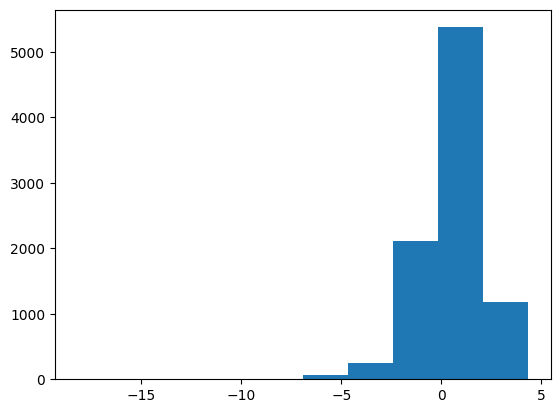

In [149]:


pred, obs = [], []
for i in range(10):
    pred.append(random.randint(0,100))
    obs.append(random.randint(0,100))
pred.sort()
obs.sort()

bs = []
for i in range(10000):
    bootstrap_sample = random.choices(obs, k=len(obs))
    bs.append(mean(bootstrap_sample) - mean(np.array(obs)) / stats.sem(bootstrap_sample))
    
bs = bs[500:9500]
import matplotlib.pyplot as plt
plt.hist(bs)
plt.show()
    

In [138]:
# BOOTSTRAP-T CONFIDENCE INTERVALS 


rank_comparison_dict = {}

# Bootstrap-t steps

# 1. 
# 1. x_1, X_2, ...., x_n is the sample drawn from distribution F
    # x_n is the accordance value at point _n
# 2. u is the mean computed from the sample, so mean(x_1, x_2,...,x_n)
# 3. F* is the resampling distribution
# 4. x*_1, x*_2,...,x*_n is a resample of the same size as the original sample
# 5. u* is the mean of the resample
# Bootstrap principle states that F* approximates F
# Variation of u is well-approximated by variation of u*

# Confidence interval degree is 1 - ci_value %
ci_value=0.05
resample_size = 0     # if 0, resample size will be same as sample
resample_freq = 10000

#rank_comparison_dict = {}

# positions in the resample lists that represent the upper and lower ci bounds 
lower_ci = int(round(resample_freq * ci_value/2)) - 1
upper_ci = int(round(resample_freq * (1-ci_value/2))) - 1

for m in all_accordance_funcs:

    rank_comparison_dict[m] = pd.DataFrame()

    rank_comparison_dict[m]['mean'] = model_means[m]
    rank_comparison_dict[m]['rank'] = model_ranks[m]


    # Accordance values for all points
    pop_sample = all_accordance_results[m]
    
    # place to store generated CI values
    ci_min_series = pd.Series()
    ci_max_series = pd.Series()
    
    # all values by model
    for col in pop_sample:
        
        
        current_sample = pop_sample[col]
        current_sample_mean = model_means[m].loc[col]
        current_sample_sem = stats.sem(current_sample)
        # our values for the 10000 samples
        resample_deltas = []
        
        # repeat resample_freq times
        for i in range(0,resample_freq):
            
            num_elements = resample_size
            
            if (resample_size == 0):
                num_elements = len(current_sample)
            
            
            # Calculate t-value for each bootstrap sample
            # formula is t = (sample_mean - population mean) / (sample sd / sqrt(sample size))
            # population mean is normalized to 0 for process
            
            
            # take mean of resample with replacement of num_elements elements, subtract from sample mean
            # Create bootstrap resample
            bootstrap_sample = random.choices(current_sample, k=num_elements)
            
            # calculate t-statistic for resample
            t_stat = (mean(bootstrap_sample) - current_sample_mean)/stats.sem(bootstrap_sample)
            #t_stat = (mean(bootstrap_sample) - current_sample_mean)/(stdev(bootstrap_sample)/math.sqrt(len(boostrap_sample))
            
            #add t-statistic to list of t-stats for CI generation
            resample_deltas.append(t_stat)
            
            #resample_deltas.append((mean(random.choices(current_sample, k=num_elements)) - current_sample_mean)/SE)
            
        # Sort differences
        resample_deltas.sort()
        
        # Set lower and upper limits of confidence interval for this model
        
        ci_max_series[col] = current_sample_mean - resample_deltas[lower_ci]*current_sample_sem
        ci_min_series[col] = current_sample_mean - resample_deltas[upper_ci]*current_sample_sem
    
    # Set the CI min and max values for this measure on all models
    rank_comparison_dict[m]['ci_min'] = ci_min_series 
    rank_comparison_dict[m]['ci_max'] = ci_max_series


/tmp/ipykernel_13832/679189962.py:41: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  ci_min_series = pd.Series()
/tmp/ipykernel_13832/679189962.py:42: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  ci_max_series = pd.Series()
/home/hma000/.conda/envs/acco/lib/python3.9/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/hma000/.conda/envs/acco/lib/python3.9/site-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/hma000/.conda/envs/acco/lib/python3.9/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, 

In [49]:
# Tell Bokeh that we'll be outputting to a Jupyter notebook. If the show(variable) function is used instead
# of the export_png(variable, filename), it will output interactively in the jupyter notebook
output_notebook()


Loading BokehJS ...

In [50]:
# Make whisker plots


model_inner_colors_dict = {"GT-ERA5":brewer['Paired'][12][0], "GT-JRA55":brewer['Paired'][12][2],
                           "GT-BSnow-ERA5":brewer['Paired'][12][4],"GT-BSnow-JRA55":brewer['Paired'][12][6],
                           "ERA5/2":brewer['Paired'][12][8], "JRA55/2":brewer['Paired'][12][10]}

model_outer_colors_dict = {"GT-ERA5":brewer['Paired'][12][1], "GT-JRA55":brewer['Paired'][12][3], 
                           "GT-BSnow-ERA5":brewer['Paired'][12][5],"GT-BSnow-JRA55":brewer['Paired'][12][7], 
                           "ERA5/2":brewer['Paired'][12][9], "JRA55/2":brewer['Paired'][12][11]}

for i in rank_comparison_dict:
    rank_comparison_dict[i]['outer_colors'] = rank_comparison_dict[i].index.map(model_outer_colors_dict)
    rank_comparison_dict[i]['inner_colors'] = rank_comparison_dict[i].index.map(model_inner_colors_dict)

annual_ci_graph_list = []

for m in all_accordance_funcs:
    graph_source_CDS = ColumnDataSource(rank_comparison_dict[m])
    
    
    r = figure(plot_width=800, plot_height=200, title="Model mean accordance/95% Confidence Interval - "+subscripted_measure_names[m], y_range=list(rank_comparison_dict[m].index))
    r.toolbar.logo = None
    r.toolbar_location = None

    r.segment('ci_min','index', 'ci_max', 'index', line_color='outer_colors', line_width=5, source=graph_source_CDS)
#    r.rect('ci_min', 'index', 0.02, 0.5, line_color='outer_colors', fill_color='outer_colors', source=graph_source_CDS)
#    r.rect('ci_max', 'index', 0.02, 0.5, line_color='outer_colors', fill_color='outer_colors', source=graph_source_CDS)

    r.circle(x='mean', y='index', color='outer_colors', size=15, fill_color='inner_colors', line_width=3, source=graph_source_CDS)
    #labels = LabelSet(x='rank', y='index', source = graph_source_CDS, text='rank', level='glyph', x_offset=-3, y_offset=10, render_mode='canvas',text_font_size="10pt")
    #r.add_layout(labels)

    r.title.text_font_size = '13pt'
    r.xaxis.axis_label = "Mean"
    r.yaxis.axis_label = "Model"
    r.xaxis.axis_label_text_font_size = "12pt"
    r.yaxis.axis_label_text_font_size = "12pt"

    
    annual_ci_graph_list.append(r)

ci_plot_grid = gridplot([annual_ci_graph_list[0:1], annual_ci_graph_list[1:2], annual_ci_graph_list[2:3]])

export_png(ci_plot_grid, filename="experiment_results/whisker_plots.png")

AttributeError: unexpected attribute 'plot_width' to figure, similar attributes are outer_width, width or min_width

In [ ]:
# Make model rank range plots

model_rank_ranges = {}
model_solid_ranks = {}
# i is accordance measure
for i in rank_comparison_dict:
    
    rank_comparison_dict[i].sort_values(by='rank', inplace=True)

    model_rank_ranges[i] = {}
    model_solid_ranks[i] = {}        
    for k in rank_comparison_dict[i]['mean'].index:
        model_ranks_list = []
        model_solid_ranks[i][k] =int(rank_comparison_dict[i]['rank'][k])
        for m in rank_comparison_dict[i]['mean'].index:
                # if 1_minimum is larger than 2_maximum or 1_max < 2_min then there's no intersection. Otherwise, they intersect

            if not ((rank_comparison_dict[i]['ci_min'][k] > rank_comparison_dict[i]['ci_max'][m]) or (rank_comparison_dict[i]['ci_max'][k] < rank_comparison_dict[i]['ci_min'][m])):
                # This means there's some overlap
                model_ranks_list.append(int(rank_comparison_dict[i]['rank'][m]))
        model_ranks_list.sort()
        model_rank_ranges[i][k] = model_ranks_list

        
    y_solid_rank = rank_comparison_dict[i]['rank']
    max_rank_dict = {}
    min_rank_dict = {}
    for n in model_rank_ranges[i]:
        max_rank_dict[n] = max(model_rank_ranges[i][n])
        min_rank_dict[n] = min(model_rank_ranges[i][n])
    rank_comparison_dict[i]['max_rank'] = pd.Series(max_rank_dict)
    rank_comparison_dict[i]['min_rank'] = pd.Series(min_rank_dict)
    

#print(model_rank_ranges)            

annual_ci_graph_list = []

for m in all_accordance_funcs:
    graph_source_CDS = ColumnDataSource(rank_comparison_dict[m])
    
    
    r = figure(plot_width=800, plot_height=200, title="Potential annual model ranks - "+subscripted_measure_names[m], x_range=(0.85,6.15), y_range=list(rank_comparison_dict[m].index))
    r.toolbar.logo = None
    r.toolbar_location = None

    r.segment('min_rank','index', 'max_rank', 'index', line_color='outer_colors', line_width=3, source=graph_source_CDS)
    r.rect('min_rank', 'index', 0.02, 0.5, line_color='outer_colors', fill_color='outer_colors', source=graph_source_CDS)
    r.rect('max_rank', 'index', 0.02, 0.5, line_color='outer_colors', fill_color='outer_colors', source=graph_source_CDS)

    r.circle(x='rank', y='index', color='outer_colors', size=15, fill_color='inner_colors', line_width=3, source=graph_source_CDS)
    #labels = LabelSet(x='rank', y='index', source = graph_source_CDS, text='rank', level='glyph', x_offset=-3, y_offset=10, render_mode='canvas',text_font_size="10pt")
    #r.add_layout(labels)

    r.title.text_font_size = '13pt'
    r.xaxis.axis_label = "Rank"
    r.yaxis.axis_label = "Model"
    r.xaxis.axis_label_text_font_size = "12pt"
    r.yaxis.axis_label_text_font_size = "12pt"
    r.xaxis.minor_tick_line_color = None  # turn off x-axis minor ticks
    r.xaxis.minor_tick_line_color = None  # turn off x-axis minor ticks
    
    annual_ci_graph_list.append(r)

ci_plot_grid = gridplot([annual_ci_graph_list[0:1], annual_ci_graph_list[1:2], annual_ci_graph_list[2:3]])

export_png(ci_plot_grid, filename="experiment_results/annual_rank_ci.png")
#show(ci_plot_grid)